<span style="color:blue"> **Chapter 5 of Jupyter Notes** </span>

# Regular Expressions, conversion to NFA

In this module, we will cover regular expressions by showing how they can be converted to NFA. The scanner and parser for RE to convert them to NFA are the main part of this module.

# Top-level functions in this module

```
This module contains the following functions that may be used in other modules to exercise concepts, compose functions, etc.

s     : string

Here are the functions

def re2nfa(s, stno = 0):
```

In [1]:
import sys
sys.path[0:0] = ['../..','../../3rdparty'] # Put these at the head of the search path

# Fix import paths later to exact low-level module

from jove.DotBashers  import dotObj_dfa
from jove.DotBashers  import dotObj_nfa

from jove.Module4_NFA import nfa2dfa
from jove.Module4_NFA import rev_dfa
from jove.Module4_NFA import mk_nfa
from jove.Module4_NFA import min_dfa_brz

from lex                 import lex
from yacc                import yacc


You may use any of these help commands:
help(ResetStNum)
help(NxtStateStr)

The DFA are NOT language equivalent!
Path leading to counterexample is: 
[(('IF', 'IF'), ('IF', 'IF')), (('A', 'A'), ('A', 'A')), (('B', 'B'), ('B', 'B'))]

Q: {'S0', 'I', 'S2', 'S1', 'F'}
Sigma: {'0', '1'}
Q0: {'I'}
F: {'F'}
Delta:
S0	I	S2	S1	F
---------------------------------------------
set()	{'I'}	{'F'}	{'S2'}	set()		0

set()	{'S0'}	set()	set()	set()		

{'S1'}	{'I', 'S0'}	{'F'}	{'S2'}	set()		1

States reached =  {'A1'}
States reached =  {'I', 'S0', 'S1'}
States reached =  {'I', 'S2', 'S0'}
States reached =  {'I', 'S0', 'F'}
States reached =  {'I', 'S0'}
States reached =  {'I', 'S0'}
States reached =  {'I', 'S0', 'S1'}
States reached =  {'S0', 'I', 'S2', 'S1'}
States reached =  {'S0', 'I', 'S2', 'F'}
NFA rejects ''
States reached =  {'I', 'S0'}
NFA rejects '0'
States reached =  {'I', 'S0', 'S1'}
States reached =  {'I', 'S2', 'S0'}
States reached =  {'I', 'S0', 'F'}
NFA accepts '100' by reaching {'I', 'S0', 

# Parsing regular expressions : ReParse


In [2]:
# -----------------------------------------------------------------------------
# reparseNEW.py
#
# Parses regular expressions (without the empty RE case)
# Produces NFA as output.
#
# The NEW signifies that I'm generating NFAs starting from
# sets of states.
#
# Adapted from calc.py that is available from 
# www.dabeaz.com/ply/example.html
# -----------------------------------------------------------------------------


#-----------------------------------------------------------------
#-- Begin lexer construction
#-----------------------------------------------------------------

#-- The tokens that constitute an RE are these
tokens = (
    'EPS','STR','LPAREN','RPAREN','PLUS','STAR'
    )

#-- The token definitions in terms of raw strings are being expressed now
t_PLUS    = r'\+'
t_STAR    = r'\*'
t_LPAREN  = r'\('
t_RPAREN  = r'\)'
t_EPS     = r'\'\'|\"\"'  # Not allowing @ for empty string anymore!
t_STR     = r'[a-zA-Z0-9]'  
# Making the above r'[a-zA-Z0-9]+' to accept strings as 
# "tokens", i.e. indivisible units that can be subject to
# RE operations

#-- Ignored characters by the lexer
t_ignore = " \t"

#-- Upon new lines, increase the lexer's line count variable
def t_newline(t):
    r'\n+'
    t.lexer.lineno += t.value.count("\n")

#-- Lexer's error announcer for illegal characters
def t_error(t):
    print("Illegal character '%s'" % t.value[0])
    t.lexer.skip(1)
    
#-- NOW BUILD THE LEXER --
lexer = lex()

#--------------------------------------------------------------------
#--- Here is the parser set-up in terms of binary operator attributes
#--------------------------------------------------------------------

#--- This is a global - for name generation in parser
NxtStateNum = 0 
def NxtStateStr():
    global NxtStateNum
    NxtStateNum += 1
    return "St"+str(NxtStateNum)

#-- Token precedences and associativity are declared in one place
#-- By declaring PLUS before STAR, we are implying that it's of lower 
#-- precedence. Also declared is that they are both left-associative.

precedence = (
    ('left','PLUS'),
    ('left','STAR'),
    )

#---------------------------------------------------------------------
#--- Here are the parsing rules for REs; each returns an NFA as "code"
#---------------------------------------------------------------------

#-- * The E -> E + C production

def p_expression_plus(t):
    '''expression : expression PLUS catexp'''
    t[0] = mk_plus_nfa(t[1], t[3]) # Union of the two NFAs is returned
    
def mk_plus_nfa(N1, N2):
    """Given two NFAs, return their union.
    """
    delta_accum = dict({})
    delta_accum.update(N1["Delta"])
    delta_accum.update(N2["Delta"]) # Simply accumulate the transitions
    # The alphabet is inferred bottom-up; thus we must union the Sigmas 
    # of the NFAs!
    return mk_nfa(Q     = N1["Q"] | N2["Q"], 
                  Sigma = N1["Sigma"] | N2["Sigma"], 
                  Delta = delta_accum, 
                  Q0    = N1["Q0"] | N2["Q0"], 
                  F     = N1["F"] | N2["F"])    

#-- * The E -> C production
    
def p_expression_plus_id(t):
    '''expression : catexp'''
    # Simply inherit the attribute from t[1] and pass on    
    t[0] = t[1] 

#-- * The C -> C O production

def p_expression_cat(t):
    '''catexp :  catexp ordyexp'''
    t[0] = mk_cat_nfa(t[1], t[2])

def mk_cat_nfa(N1, N2):
    delta_accum = dict({}) 
    delta_accum.update(N1["Delta"])
    delta_accum.update(N2["Delta"])
    # Now, introduce moves from every one of N1's final states
    # to the set of N2's initial states.
    for f in N1["F"]:
        # However, N1's final states may already have epsilon moves to
        # other N1-states!
        # Expand the target of such jumps to include N2's Q0 also!
        if (f, "") in N1["Delta"]: 
            delta_accum.update({ (f,""):(N2["Q0"] | N1["Delta"][(f, "")])
                               })
        else:
            delta_accum.update({ (f, ""): N2["Q0"] })
    # In syntax-directed translation, it is impossible
    # that N2 and N1 have common states. Check anyhow
    # in case there are bugs elsewhere that cause it.
    assert((N2["F"] & N1["F"]) == set({})) 
    return mk_nfa(Q     = N1["Q"] | N2["Q"], 
                  Sigma = N1["Sigma"] | N2["Sigma"], 
                  Delta = delta_accum, 
                  Q0    = N1["Q0"],
                  F     = N2["F"])

#-- * The C -> O production

def p_expression_cat_id(t):
    '''catexp :  ordyexp'''
    # Simply inherit the attribute from t[1] and pass on
    t[0] = t[1]

#-- * The O -> O STAR production

def p_expression_ordy_star(t):
    'ordyexp : ordyexp STAR'
    t[0] = mk_star_nfa(t[1])

def mk_star_nfa(N):
    # Follow construction from Kozen's book:
    # 1) Introduce new (single) start+final state IF
    # 2) Let Q0 = set({ IF })
    # 2) Move on epsilon from IF to the set N[Q0]
    # 3) Make N[F] non-final
    # 4) Spin back from every state in N[F] to Q0
    #
    delta_accum = dict({})
    IF = NxtStateStr()
    Q0 = set({ IF }) # new set of start + final states
    # Jump from IF to N's start state set
    delta_accum.update({ (IF,""): N["Q0"] })
    delta_accum.update(N["Delta"])
    #
    for f in N["F"]:
        # N's final states may already have epsilon moves to
        # other N-states!
        # Expand the target of such jumps to include Q0 also.
        if (f, "") in N["Delta"]:
            delta_accum.update({ (f, ""): (Q0 | N["Delta"][(f, "")]) })
        else:
            delta_accum.update({ (f, ""): Q0 })
    #
    return mk_nfa(Q     = N["Q"] | Q0, 
                  Sigma = N["Sigma"], 
                  Delta = delta_accum, 
                  Q0    = Q0, 
                  F     = Q0)

#-- * The O -> ( E ) production

def p_expression_ordy_paren(t):
    'ordyexp : LPAREN expression RPAREN'
    # Simply inherit the attribute from t[2] and pass on
    t[0] = t[2]

#-- * The O -> EPS production
    
def p_expression_ordy_eps(t):
    'ordyexp : EPS'
    t[0] = mk_eps_nfa()

def mk_eps_nfa():
    """An nfa with exactly one start+final state
    """
    Q0 = set({ NxtStateStr() })
    F  = Q0
    return mk_nfa(Q     = Q0, 
                  Sigma = set({}), 
                  Delta = dict({}), 
                  Q0    = Q0, 
                  F     = Q0)                      

#-- * The O -> STR production, i.e. a single re letter

def p_expression_ordy_str(t):
    'ordyexp : STR'
    t[0] = mk_symbol_nfa(t[1])

def mk_symbol_nfa(a):
    """The NFA for a single re letter
    """
    # Make a fresh initial state
    q0 = NxtStateStr()
    Q0 = set({ q0 })
    # Make a fresh final state
    f = NxtStateStr()
    F = set({ f })
    return mk_nfa(Q     = Q0 | F, 
                  Sigma = set({a}), 
                  Delta = { (q0,a): F },
                  Q0    = Q0, 
                  F     = F)

def p_error(t):
    print("Syntax error at '%s'" % t.value)

#-- NOW BUILD THE PARSER --    
parser = yacc()

# End of reparseNEW.py
# -----------------------------------------------------------------------------


Generating LALR tables


## RE to NFA code

In [3]:
def re2nfa(s, stno = 0):
    global NxtStateNum
    NxtStateNum = stno
    myparsednfa = parser.parse(s)
    #-- for debugging : return dotObj_nfa(myparsednfa, nfaname)
    return myparsednfa

In [4]:
re2nfa("(bb*+cc)(c+d*)")

{'Delta': {('St1', 'b'): {'St2'},
  ('St10', 'c'): {'St11'},
  ('St12', 'd'): {'St13'},
  ('St13', ''): {'St14'},
  ('St14', ''): {'St12'},
  ('St2', ''): {'St5'},
  ('St3', 'b'): {'St4'},
  ('St4', ''): {'St5'},
  ('St5', ''): {'St10', 'St14', 'St3'},
  ('St6', 'c'): {'St7'},
  ('St7', ''): {'St8'},
  ('St8', 'c'): {'St9'},
  ('St9', ''): {'St10', 'St14'}},
 'F': {'St11', 'St14'},
 'Q': {'St1',
  'St10',
  'St11',
  'St12',
  'St13',
  'St14',
  'St2',
  'St3',
  'St4',
  'St5',
  'St6',
  'St7',
  'St8',
  'St9'},
 'Q0': {'St1', 'St6'},
 'Sigma': {'b', 'c', 'd'}}

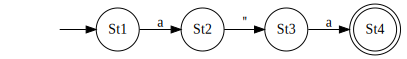

In [5]:
dotObj_nfa(re2nfa("aa"))

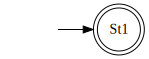

In [6]:
dotObj_nfa(re2nfa("''"))

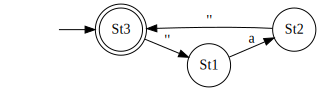

In [7]:
dotObj_nfa(re2nfa("a*"))

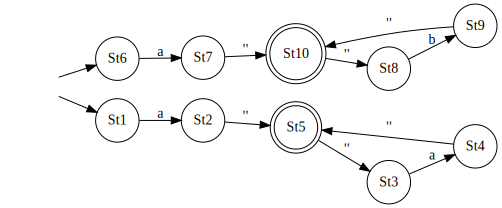

In [8]:
dotObj_nfa(re2nfa("aa*+ab*"), "n")

In [9]:
re2nfa("(aa*+ab*)*")

{'Delta': {('St1', 'a'): {'St2'},
  ('St10', ''): {'St11', 'St8'},
  ('St11', ''): {'St1', 'St6'},
  ('St2', ''): {'St5'},
  ('St3', 'a'): {'St4'},
  ('St4', ''): {'St5'},
  ('St5', ''): {'St11', 'St3'},
  ('St6', 'a'): {'St7'},
  ('St7', ''): {'St10'},
  ('St8', 'b'): {'St9'},
  ('St9', ''): {'St10'}},
 'F': {'St11'},
 'Q': {'St1',
  'St10',
  'St11',
  'St2',
  'St3',
  'St4',
  'St5',
  'St6',
  'St7',
  'St8',
  'St9'},
 'Q0': {'St11'},
 'Sigma': {'a', 'b'}}

In [10]:
re2nfa("a*b")

{'Delta': {('St1', 'a'): {'St2'},
  ('St2', ''): {'St3'},
  ('St3', ''): {'St1', 'St4'},
  ('St4', 'b'): {'St5'}},
 'F': {'St5'},
 'Q': {'St1', 'St2', 'St3', 'St4', 'St5'},
 'Q0': {'St3'},
 'Sigma': {'a', 'b'}}

In [11]:
re2nfa("(a*b)*")

{'Delta': {('St1', 'a'): {'St2'},
  ('St2', ''): {'St3'},
  ('St3', ''): {'St1', 'St4'},
  ('St4', 'b'): {'St5'},
  ('St5', ''): {'St6'},
  ('St6', ''): {'St3'}},
 'F': {'St6'},
 'Q': {'St1', 'St2', 'St3', 'St4', 'St5', 'St6'},
 'Q0': {'St6'},
 'Sigma': {'a', 'b'}}

In [12]:
re2nfa("a*b")

{'Delta': {('St1', 'a'): {'St2'},
  ('St2', ''): {'St3'},
  ('St3', ''): {'St1', 'St4'},
  ('St4', 'b'): {'St5'}},
 'F': {'St5'},
 'Q': {'St1', 'St2', 'St3', 'St4', 'St5'},
 'Q0': {'St3'},
 'Sigma': {'a', 'b'}}

In [13]:
astarbnfa = re2nfa("a*b")

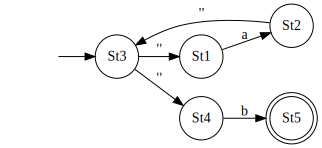

In [14]:
dotObj_nfa(astarbnfa)

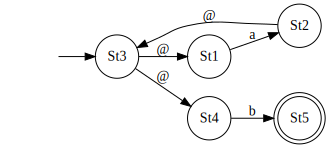

In [15]:
dotObj_nfa(astarbnfa, visible_eps=True)

In [16]:
astarbdfa = nfa2dfa(astarbnfa)

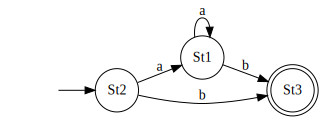

In [17]:
dotObj_dfa(astarbdfa)

In [18]:
rev_dfa(astarbdfa)

{'Delta': {('BH', 'a'): {'BH', 'St3'},
  ('BH', 'b'): {'BH', 'St3'},
  ('St1', 'a'): {'St1', 'St2'},
  ('St1', 'b'): set(),
  ('St2', 'a'): set(),
  ('St2', 'b'): set(),
  ('St3', 'a'): set(),
  ('St3', 'b'): {'St1', 'St2'}},
 'F': {'St2'},
 'Q': {'BH', 'St1', 'St2', 'St3'},
 'Q0': {'St3'},
 'Sigma': {'a', 'b'}}

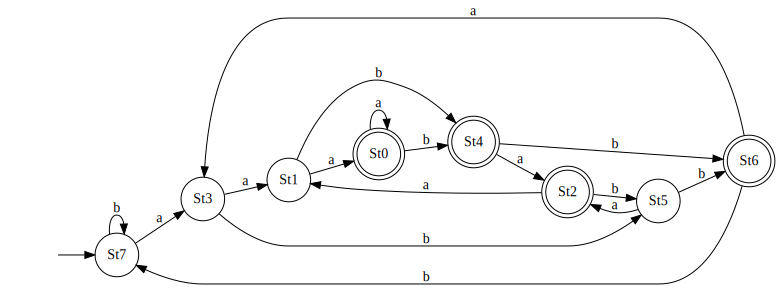

In [19]:
dotObj_dfa(min_dfa_brz(nfa2dfa(re2nfa("(a+b)*a(a+b)(a+b)"))))

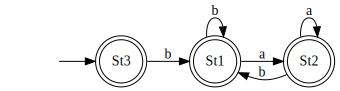

In [20]:
dotObj_dfa(nfa2dfa(re2nfa("(b*+ba*)*")))

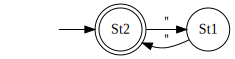

In [21]:
dotObj_nfa(re2nfa("''*"))

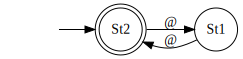

In [22]:
dotObj_nfa(re2nfa("''*"), visible_eps=True)

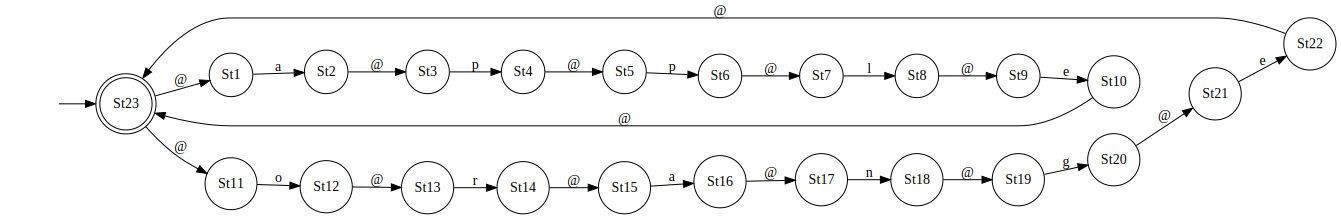

In [23]:
dotObj_nfa(re2nfa("(apple+orange)*"), visible_eps=True)

If you want to have some fun, change the STR RE to have  "+" at the end, as recommended in the comments below t_STR (early part of these notes). Then you can accept "apple" as a single token.